In [24]:

import random

import pandas as pd
import matplotlib.pyplot as plt

from source import model_builder, image_processor

from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split

from datetime import datetime

In [25]:
image_size = (32, 32)
input_size = (*image_size, 1)

In [26]:
df_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
            'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [27]:
df_train = image_processor.process_image_data_with_edges("../data/Train", image_size, targets=df_names)

In [28]:
X = df_train.drop(columns=['target'])
y = df_train['target']

In [29]:
X_data = X.values.reshape(-1, *image_size, 1).astype('float32')
y_data = y.factorize()[0]

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.05, stratify=y_data, random_state=42)

In [31]:
model = model_builder.build_conv_pool_model(input_size, len(df_names))

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stopping, tensorboard_callback],
                    validation_data=(X_val, y_val),
                    verbose=1)

for epoch, (val_loss, val_acc) in enumerate(zip(history.history['val_loss'], history.history['val_accuracy']), start=1):
    print(f"Epoch {epoch}: val_loss={val_loss:.4f}, val_accuracy={val_acc:.4f}")

score = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Accuracy: {score[1] * 100:.2f}%")

Epoch 1/100
780/780 [==============================] - 18s 23ms/step - loss: 1.0583 - accuracy: 0.6944 - val_loss: 0.4589 - val_accuracy: 0.8435
Epoch 2/100
780/780 [==============================] - 16s 21ms/step - loss: 0.5044 - accuracy: 0.8184 - val_loss: 0.3585 - val_accuracy: 0.8706
Epoch 3/100
780/780 [==============================] - 16s 21ms/step - loss: 0.4152 - accuracy: 0.8437 - val_loss: 0.3340 - val_accuracy: 0.8622
Epoch 4/100
780/780 [==============================] - 16s 20ms/step - loss: 0.3669 - accuracy: 0.8585 - val_loss: 0.2905 - val_accuracy: 0.8812
Epoch 5/100
780/780 [==============================] - 16s 20ms/step - loss: 0.3299 - accuracy: 0.8696 - val_loss: 0.2799 - val_accuracy: 0.8877
Epoch 6/100
780/780 [==============================] - 16s 20ms/step - loss: 0.3070 - accuracy: 0.8767 - val_loss: 0.2648 - val_accuracy: 0.8911
Epoch 7/100
780/780 [==============================] - 160s 205ms/step - loss: 0.2881 - accuracy: 0.8828 - val_loss: 0.2496 - val_

In [46]:
from keras.callbacks import Callback


class CustomEarlyStopping(Callback):
    def __init__(self, patience=10, loss_weight=0.5, acc_weight=0.5, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.loss_weight = loss_weight
        self.acc_weight = acc_weight
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.best_weights = None
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        # Kombinált metrika számítása
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_accuracy')
        if val_loss is not None and val_acc is not None:
            # Kombinált metrika: kisebb érték jobb
            score = self.loss_weight * val_loss - self.acc_weight * val_acc

            # Első iteráció vagy új legjobb érték
            if self.best_score is None or score < self.best_score:
                self.best_score = score
                self.best_weights = self.model.get_weights()
                self.wait = 0  # Reset the patience counter
            else:
                self.wait += 1  # Increment the patience counter

            # Ha túlléptük a patience értéket, állítsuk le a tanítást
            if self.wait >= self.patience:
                self.model.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.best_weights is not None and self.restore_best_weights:
            print("Restoring best model weights from early stopping.")

# Használat:
custom_early_stopping = CustomEarlyStopping(patience=20, loss_weight=0.6, acc_weight=0.4, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64,
                    callbacks=[custom_early_stopping, tensorboard_callback],
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/200
780/780 [==============================] - 17s 21ms/step - loss: 0.1799 - accuracy: 0.9277 - val_loss: 0.2051 - val_accuracy: 0.9216
Epoch 2/200
780/780 [==============================] - 16s 21ms/step - loss: 0.1665 - accuracy: 0.9314 - val_loss: 0.2091 - val_accuracy: 0.9265
Epoch 3/200
780/780 [==============================] - 16s 21ms/step - loss: 0.1538 - accuracy: 0.9350 - val_loss: 0.2033 - val_accuracy: 0.9273
Epoch 4/200
780/780 [==============================] - 16s 21ms/step - loss: 0.1536 - accuracy: 0.9364 - val_loss: 0.2267 - val_accuracy: 0.9246
Epoch 5/200
780/780 [==============================] - 16s 21ms/step - loss: 0.1470 - accuracy: 0.9407 - val_loss: 0.2277 - val_accuracy: 0.9284
Epoch 6/200
780/780 [==============================] - 17s 21ms/step - loss: 0.1436 - accuracy: 0.9408 - val_loss: 0.2094 - val_accuracy: 0.9250
Epoch 7/200
780/780 [==============================] - 16s 21ms/step - loss: 0.1428 - accuracy: 0.9413 - val_loss: 0.2208 - val_ac

In [47]:
for epoch, (val_loss, val_acc) in enumerate(zip(history.history['val_loss'], history.history['val_accuracy']), start=1):
    print(f"Epoch {epoch}: val_loss={val_loss:.4f}, val_accuracy={val_acc:.4f}")

score = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Accuracy: {score[1] * 100:.2f}%")

Epoch 1: val_loss=0.2051, val_accuracy=0.9216
Epoch 2: val_loss=0.2091, val_accuracy=0.9265
Epoch 3: val_loss=0.2033, val_accuracy=0.9273
Epoch 4: val_loss=0.2267, val_accuracy=0.9246
Epoch 5: val_loss=0.2277, val_accuracy=0.9284
Epoch 6: val_loss=0.2094, val_accuracy=0.9250
Epoch 7: val_loss=0.2208, val_accuracy=0.9296
Epoch 8: val_loss=0.2181, val_accuracy=0.9262
Epoch 9: val_loss=0.2191, val_accuracy=0.9262
Epoch 10: val_loss=0.2042, val_accuracy=0.9296
Epoch 11: val_loss=0.2027, val_accuracy=0.9303
Epoch 12: val_loss=0.1956, val_accuracy=0.9296
Epoch 13: val_loss=0.2299, val_accuracy=0.9277
Epoch 14: val_loss=0.1965, val_accuracy=0.9281
Epoch 15: val_loss=0.2143, val_accuracy=0.9300
Epoch 16: val_loss=0.2213, val_accuracy=0.9284
Epoch 17: val_loss=0.2327, val_accuracy=0.9322
Epoch 18: val_loss=0.2296, val_accuracy=0.9254
Epoch 19: val_loss=0.2236, val_accuracy=0.9315
Epoch 20: val_loss=0.2248, val_accuracy=0.9330
Epoch 21: val_loss=0.2279, val_accuracy=0.9319
Epoch 22: val_loss=0.2

In [32]:
test_df = image_processor.process_image_data_with_edges("../data/TestData", image_size)

In [33]:
X_test = test_df.iloc[:, 1:]
X_test_prepared = X_test.values.reshape(-1, *image_size, 1).astype('float32')

In [34]:


# model = load_model("models/model_final2")
pred = model.predict(X_test_prepared)

222/222 [==============================] - 1s 5ms/step


In [35]:
pred

array([[1.58276441e-12, 7.12718509e-16, 8.89499962e-01, ...,
        1.32726607e-11, 8.19335294e-11, 2.42671572e-09],
       [7.12199939e-13, 1.41576315e-08, 3.41386316e-13, ...,
        9.18642108e-05, 1.14118293e-09, 4.11086880e-08],
       [1.56674899e-11, 4.60723975e-08, 2.07083780e-13, ...,
        6.00002095e-05, 2.66356182e-09, 5.49511381e-10],
       ...,
       [4.89338225e-13, 1.62911948e-17, 9.69279062e-20, ...,
        2.24581233e-21, 4.86738362e-13, 1.54895089e-19],
       [5.41561902e-01, 2.27042257e-11, 7.31727786e-12, ...,
        8.54128373e-15, 6.95999953e-13, 1.20802501e-14],
       [1.70576934e-17, 2.07784590e-09, 2.32039878e-19, ...,
        4.05460908e-15, 6.58470001e-10, 6.94093610e-15]], dtype=float32)

In [36]:
predicted_classes = pred.argmax(axis=1)
len(predicted_classes)

7100

In [37]:
pd.DataFrame(pred[3086])

,0
0,6.348813e-14
1,9.826810e-09
2,1.435490e-11
3,4.828588e-10
4,9.414839e-01
...,...
57,5.755789e-09
58,4.011450e-05
59,1.650517e-06
60,8.151402e-10


In [38]:
predicted_labels = [df_names[i] for i in predicted_classes]

test_df['pred'] = predicted_classes + 1
test_df['pred_labels'] = predicted_labels

In [39]:
#model.save("models/model_final2")

In [40]:
filtered_df = test_df[test_df['target'] == 'Test0322.png']
filtered_df[['target', 'pred', 'pred_labels']]

,target,pred,pred_labels
1155,Test0322.png,40,d


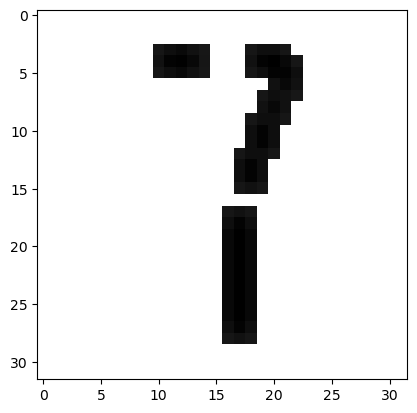

In [41]:
plt.imshow(X_test_prepared[2112], cmap='gray')

In [42]:
df_lead = test_df[['pred', 'target']].sort_values(by=['target'], ascending=True).reset_index(drop=True)

In [43]:
df_lead.columns = ['class', 'TestImage']

In [44]:
df_lead

,class,TestImage
0,19,Test0001.png
1,19,Test0002.png
2,45,Test0003.png
3,45,Test0004.png
4,45,Test0005.png
...,...,...
7095,18,Test7096.png
7096,18,Test7097.png
7097,18,Test7098.png
7098,18,Test7099.png


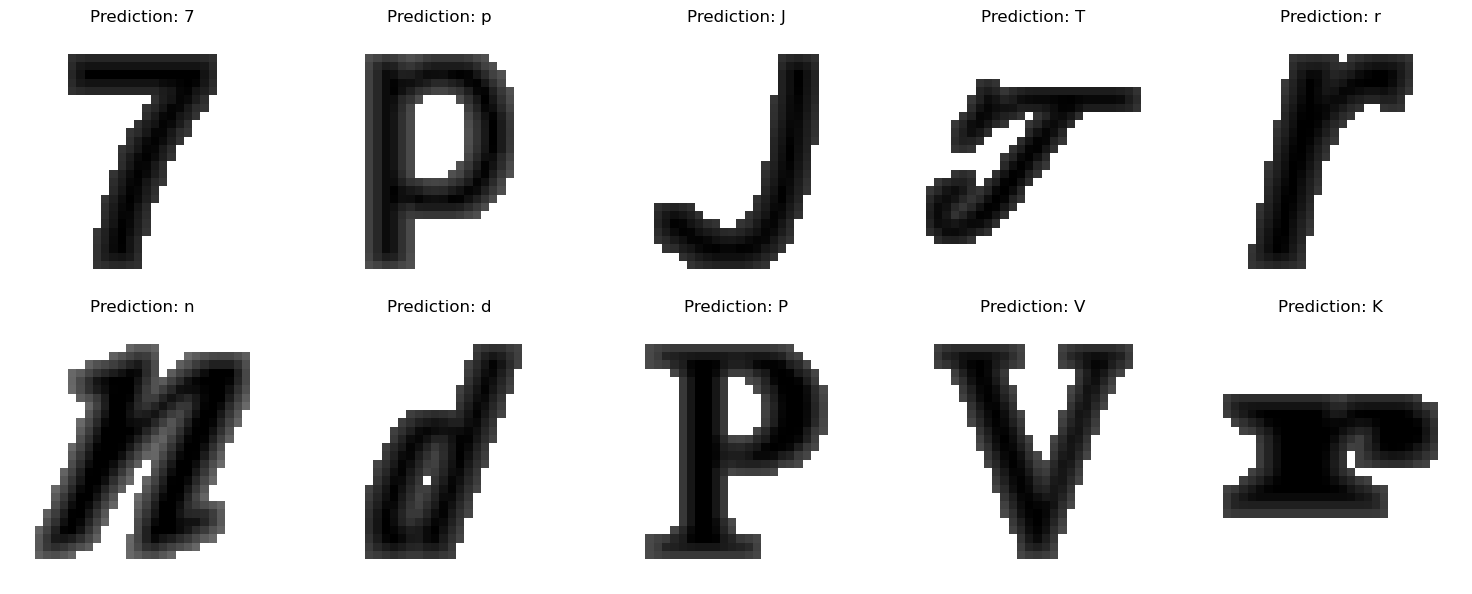

In [45]:
random_ids = random.sample(list(test_df.index), min(10, len(test_df)))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, img_id in zip(axes.flatten(), random_ids):
    pred_label = test_df.loc[img_id, 'pred_labels']
    ax.imshow(X_test_prepared[img_id], cmap='gray')
    ax.set_title(f"Prediction: {pred_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()